In [1]:
# imports 
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import doc,arch_model
from datetime import datetime, timedelta
from pytz import timezone
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
# Function to collect historical data for a cryptocurrency using yfinance
def fetch_crypto_data(symbol, start_date, end_date, priod):
    data = yf.Ticker(symbol)
    
    tickerDf = data.history(period=priod, start=start_date, end=end_date)
    tickerDf = tickerDf[['Close']]
    # print(tickerDf)   
    
    return tickerDf


# Function to perform the Augmented Dickey-Fuller (ADF) test
def perform_adf_test(series):
    result = adfuller(series)
    return result[1]  # Returning p-value

# Function to plot the price chart
def plot_price_chart(crypto, timeframe, start_date, end_date, p_value=0):
    # Collect historical data
    data = fetch_crypto_data(crypto, start_date, end_date, timeframe)

    # Plot the price chart
    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp'], data['price'], label=f"{crypto} - {timeframe}")
    plt.title(f"Price Chart for {crypto} ({timeframe} timeframe); P value is{p_value}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [3]:

def plot_price_chart(data, timeframe, start_date, end_date, p_value=0):

    # Plot the price chart
    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp'], data['price'])
    plt.title(f"Price Chart ({timeframe} timeframe); P value is{p_value}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


def predict_and_plot(data:pd.DataFrame, train_end, test_end, p=0,q=0,plot_option=False):
    train_data = data.loc[:train_end]#.loc???
    test_data = data.loc[train_end + timedelta(days=1):test_end]
    
    model = ARIMA(train_data, order=(p,0,q))
    model_fit = model.fit()
    # print(model_fit.summary())
    
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data['Close'] - predictions

    if plot_option:
        plt.figure(figsize=(10, 6))
        plt.plot(test_data.index, test_data['Close'], label='Actual')
        plt.plot(predictions.index, predictions, label='Predicted')
        plt.title(f'ARIMA Model Predictions. ARMA({p},{q})')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data['Close'], label='Actual')
        plt.plot(predictions.index, predictions, label='Predicted', color='red')
        plt.title(f'ARIMA Model Predictions. ARMA({p},{q})')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()
        
def get_mse_msp(data:pd.DataFrame,train_data, test_data, train_end, test_end,p,q):
    model = ARIMA(train_data, order=(p,0,q))
    model_fit = model.fit()
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data['Close'] - predictions
    # temp_mape = round(np.mean(abs(residuals/test_data.Close)),8)
    # temp_mse = round(np.sqrt(np.mean(residuals**2)),8)
    temp_mape = np.mean(abs(residuals/test_data.Close))
    temp_mse = np.sqrt(np.mean(residuals**2))
    
    return (temp_mape, temp_mse)
  

## New codes

In [9]:

def get_aic(train_data, p, q):
    model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    aic = model_fit.aic
    return aic

def find_best_arima(train_data, max_loop=6):
    best_aic = float('inf')
    best_combination = {'p': 111, 'q': 111}

    for p in range(1, max_loop):
        for q in range(1, max_loop):
            temp_aic = get_aic(train_data, p, q)
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_combination['p'] = p
                best_combination['q'] = q

    return (best_combination['p'], best_combination['q'])

def fill_prediction2(data:pd.DataFrame, to_predict_windows:int,  window_size=30*10, prediction_period=30, find_best_p_q_once =False):
    if find_best_p_q_once:
        p, q = find_best_arima(data)
    for _ in range(to_predict_windows):
        print("-------------------------",_)
        i = data.shape[0]
        train_data = data.iloc[-window_size:-1].copy()
        train_data['Close'].fillna(train_data['prediction'], inplace=True)
        # Fit the ARIMA model
        if not find_best_p_q_once:
            p, q = find_best_arima(train_data)
        model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        
        # Make a one-step prediction
        prediction = model_fit.forecast(steps=prediction_period)
        # Store the prediction
        for j in range(prediction_period):
            if i+j < len(data):
                # If the date index exists, update the 'prediction' column
                data.loc[data.index[i+j], 'prediction'] = prediction[j]
            else:
                # If the date index doesn't exist, create it and add the prediction
                next_date = data.index[-1] + pd.DateOffset(days=1)
                data.loc[next_date, 'prediction'] = prediction[j]
        del train_data
        del model
        del model_fit
        
# def fill_prediction3(data:pd.DataFrame, start_date, end_date,  window_size=30*10, prediction_period=30, find_best_p_q_once =False):
#     if find_best_p_q_once:
#         p, q = find_best_arima(data)
#     # current_date = start_date
#     # while current_date < end_date:
#     for index, row in data.iterrows():
#         current_date = index
#         print("-------------------------",current_date)
#         i = data.shape[0]
#         train_data = data.iloc[-window_size:-1].copy()
#         # train_data['Close'].fillna(train_data['prediction'], inplace=True)
#         # Fit the ARIMA model
#         if not find_best_p_q_once:
#             p, q = find_best_arima(train_data)
#         model = ARIMA(train_data['Close'], order=(p, 0, q))
#         # model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
#         model_fit = model.fit()
        
#         # Make a one-step prediction
#         prediction = model_fit.forecast(steps=prediction_period)
#         # Store the prediction
#         # data[data.index[current_date],'prediction'] = prediction[0]
#         data.loc[current_date, 'prediction'] = prediction[0]
            
#         del train_data
#         del model
#         del model_fit


# def fill_prediction3(data:pd.DataFrame, start_date, end_date,  window_size=30*10, prediction_period=30, find_best_p_q_once =False):
#     if find_best_p_q_once:
#         p, q = find_best_arima(data)
#     current_date = start_date
#     while current_date < end_date:
#         print("-------------------------",current_date)
#         i = data.shape[0]
#         train_data = data.iloc[-window_size:-1].copy()
#         # train_data['Close'].fillna(train_data['prediction'], inplace=True)
#         # Fit the ARIMA model
#         if not find_best_p_q_once:
#             p, q = find_best_arima(train_data)
#         model = ARIMA(train_data['Close'], order=(p, 0, q))
#         # model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
#         model_fit = model.fit()
        
#         # Make a one-step prediction
#         prediction = model_fit.forecast(steps=prediction_period)
#         # Store the prediction
#         data.loc[current_date,'prediction'] = prediction[0]
            
#         del train_data
#         del model
#         del model_fit
#         current_date += timedelta(days=1)  # increment the current_date
# def fill_prediction3(data:pd.DataFrame, train_end, test_end, window_size=30*10, prediction_period=30, find_best_p_q_once =False):
#     if find_best_p_q_once:
#         p, q = find_best_arima(data)
#     current_date = train_end + timedelta(days=1)  # start the day after train_end
#     while current_date <= test_end:  # loop until test_end
#         print("-------------------------",current_date)
#         # Use data from 'window_size' days before the current_date for training
#         train_data = data.loc[(current_date-timedelta(days=window_size)):current_date-timedelta(days=1), 'Close'].copy()
#         # Fit the ARIMA model
#         if not find_best_p_q_once:
#             p, q = find_best_arima(train_data)
#         model = ARIMA(train_data, order=(p, 0, q))
#         model_fit = model.fit()
        
#         # Make a one-step prediction
#         prediction = model_fit.forecast(steps=prediction_period)
#         # Store the prediction
#         data.loc[current_date,'prediction'] = prediction[0]
            
#         del train_data
#         del model
#         del model_fit
#         current_date += timedelta(days=1)  # increment the current_date

def fill_prediction4(data:pd.DataFrame, to_predict_windows:int,  window_size=30*10, prediction_period=30, find_best_p_q_once =False):
    if find_best_p_q_once:
        p, q = find_best_arima(data)
    for _ in range(to_predict_windows):
        print("-------------------------",_)
        i = data.shape[0]
        train_data = data.iloc[-window_size:-1].copy()
        train_data['Close'].fillna(train_data['prediction'], inplace=True)
        # Fit the ARIMA model
        if not find_best_p_q_once:
            p, q = find_best_arima(train_data)
        model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        
        # Make a one-step prediction
        prediction = model_fit.forecast(steps=prediction_period)
        # Store the prediction
        for j in range(prediction_period):
            if i+j < len(data):
                # If the date index exists, update the 'prediction' column
                data.loc[data.index[i+j], 'prediction'] = prediction[j]
            else:
                # If the date index doesn't exist, create it and add the prediction
                next_date = data.index[-1] + pd.DateOffset(days=1)
                data.loc[next_date, 'prediction'] = prediction[j]
        del train_data
        del model
        del model_fit           

In [5]:

# Cofigurations
top_cryptos = ['BTC-USD', 'ETH-USD']  
time_frames = ['1d']

start_date = datetime(2021, 7, 1, tzinfo=timezone('Asia/Tehran'))
end_date = datetime(2023, 12, 1, tzinfo=timezone('Asia/Tehran'))

train_end = datetime(2023,7,1, tzinfo=timezone('Asia/Tehran'))
test_end = datetime(2023,12,1, tzinfo=timezone('Asia/Tehran') )

In [ ]:
# RUN ONE TIME. USE .CSV THAT STORED
# del data
data = fetch_crypto_data('BTC-USD', start_date, test_end, '1d')

# Initialize the 'prediction' column
data['prediction'] = np.nan
# print(data)


In [ ]:
# RUN ONE TIME. USE .CSV THAT STORED
# Fill the 'prediction' column using the ARIMA model with a rolling window
# fill_prediction2(data, window_size=30*12, prediction_period=1, to_predict_windows=155,find_best_p_q_once=True)# prediction_period * to_predict_windows must be 155
fill_prediction3(data,  train_end=train_end, test_end=test_end , window_size=30*12, prediction_period=1, find_best_p_q_once=True)# prediction_period * to_predict_windows must be 155

# Print the data
print(data)


In [ ]:
# RUN ONE TIME. USE .CSV THAT STORED
new_start_date = datetime(2023, 7, 1, tzinfo=timezone('Asia/Tehran'))
new_end_date = datetime(2023, 12, 3, tzinfo=timezone('Asia/Tehran'))

# Fetch new data for the specified date range
new_data = fetch_crypto_data('USDT-USD', new_start_date, new_end_date, '1d')
# for date_ in range(new_data['Date']):
#     data.loc(date_)['Close'] =  new_data.loc(date_)['Close']
print(new_data.iterrows())
print(new_data)
for date_, row in new_data.iterrows():
    data.loc[date_, 'Close'] = row['Close']
print(data.tail(100))


In [ ]:
# RUN ONE TIME. USE .CSV THAT STORED
data['residual'] = data['Close'] - data['prediction']
data.tail(20)

In [ ]:
# data.to_csv('arima_result.csv', index=False)4
data.to_csv('arima_result.csv', index=True)  # Set index=False to include the 'Date' column


In [16]:
data.tail()

,Close,prediction,residual
Date,,,
2023-11-28 00:00:00+00:00,1.000377,1.000439,-0.000061
2023-11-29 00:00:00+00:00,1.000220,1.000440,-0.000220
2023-11-30 00:00:00+00:00,1.000156,1.000441,-0.000285
2023-12-01 00:00:00+00:00,1.000185,1.000442,-0.000257
2023-12-02 00:00:00+00:00,1.000364,1.000443,-0.000079


In [15]:

data = pd.read_csv('arima_result.csv', )
data['Date'] = pd.to_datetime(data['Date'])


# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

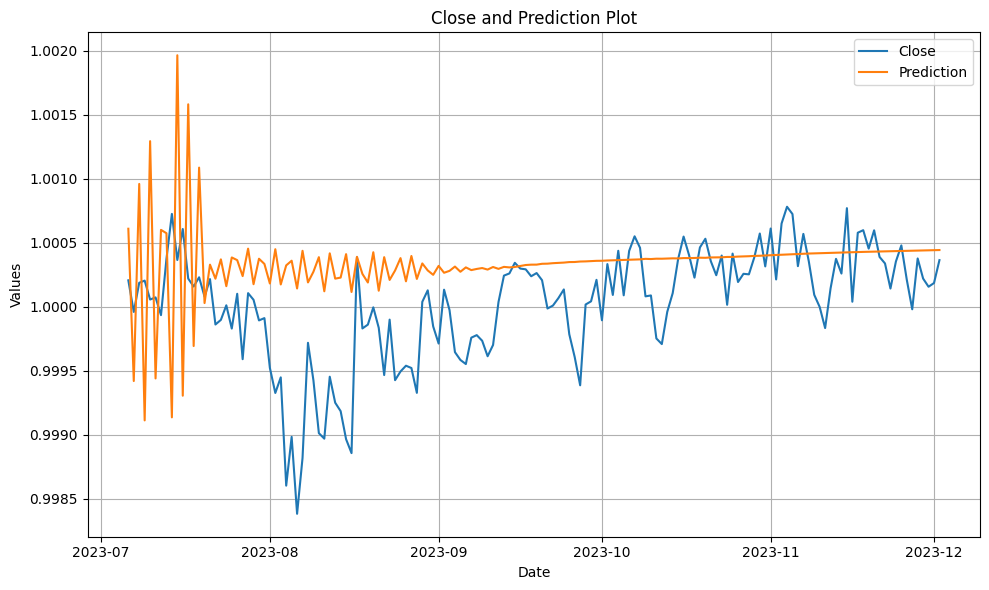

In [17]:

# Get the last 160 rows
df_last_160 = data.iloc[-150:]

# Plot the 'Close' and 'prediction' columns
plt.figure(figsize=(10, 6))
plt.plot(df_last_160.index, df_last_160['Close'], label='Close')
plt.plot(df_last_160.index, df_last_160['prediction'], label='Prediction')

# Customize the plot
plt.title('Close and Prediction Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# 2nd Part


In [19]:

trimmed_data = data.loc[start_date: train_end]

best_p, best_q = find_best_arima(trimmed_data,  )

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\user\AppData\Local\Programs\Python\

In [20]:
trimmed_data = data.loc[train_end  : test_end]
trimmed_data.head()

,Close,prediction,residual
Date,,,
2023-07-01 00:00:00+00:00,1.000129,0.999859,0.000270
2023-07-02 00:00:00+00:00,1.000085,1.000219,-0.000134
2023-07-03 00:00:00+00:00,0.999998,0.999765,0.000233
2023-07-04 00:00:00+00:00,1.000301,1.000387,-0.000086
2023-07-05 00:00:00+00:00,1.000094,0.999642,0.000452


garch_model = arch_model(trimmed_data['residual'], p=best_p, q=best_q, vol="GARCH")

In [27]:
garch_fit_model = garch_model.fit(disp='off')
garch_fit_model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.646e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               residual   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                969.066
Distribution:                  Normal   AIC:                          -1930.13
Method:            Maximum Likelihood   BIC:                          -1918.01
                                        No. Observations:                  153
Date:                Sat, Jan 06 2024   Df Residuals:                      152
Time:                        15:48:23   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.1235e-04  7.048e-08  -4431.846      0.000 [-3.125e-04,-3.122e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.2915e-09  1.407e-11    376.011      0.000 [5.264e-09,5.319e-09]
alpha[1]       0.2000      0.769      0.260      0.795     [ -1.308,  1.708]
beta[1]        0.7800      0.591      1.321      0.187     [ -0.378,  1.938]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

In [34]:
garch_fit_model.forecast(horizon=1).mean

,h.1
Date,
2023-11-30 00:00:00+00:00,-0.000312


In [ ]:
def rolling_window(data:pd.DataFrame, to_predict_windows:int,  window_size=30*10, prediction_period=30, find_best_p_q_once =False):
    if find_best_p_q_once:
        p, q = find_best_arima(data)
    for _ in range(to_predict_windows):
        print("-------------------------",_)
        i = data.shape[0]
        train_data = data.iloc[-window_size:-1].copy()
        train_data['Close'].fillna(train_data['prediction'], inplace=True)
        # Fit the ARIMA model
        if not find_best_p_q_once:
            p, q = find_best_arima(train_data)
        model = ARIMA(train_data['Close'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        
        # Make a one-step prediction
        prediction = model_fit.forecast(steps=prediction_period)
        # Store the prediction
        for j in range(prediction_period):
            if i+j < len(data):
                # If the date index exists, update the 'prediction' column
                data.loc[data.index[i+j], 'prediction'] = prediction[j]
            else:
                # If the date index doesn't exist, create it and add the prediction
                next_date = data.index[-1] + pd.DateOffset(days=1)
                data.loc[next_date, 'prediction'] = prediction[j]
        del train_data
        del model
        del model_fit           

In [28]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import skew, kurtosis

# Obtain the S&P500 returns and truncate the NA value
data = yf.download('^GSPC', start='2021-01-01')
data['log_return'] = np.log(data['Close']).diff()
data = data.dropna()

# Create the forecasts list to store the predictions
window_length = 500
fore_length = len(data) - window_length
forecasts = []

for d in range(fore_length):
    # Obtain the S&P500 rolling window for this day
    data_offset = data['log_return'].iloc[d : window_length + d]

    # Fit the ARIMA model
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5)  # [0,1,2,3,4]
    for i in pq_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(data_offset, order=(i,0,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, 0, j)
                    best_mdl = tmp_mdl
            except: continue

    # Specify and fit the GARCH model
    p_ = best_order[0]
    o_ = best_order[1]
    q_ = best_order[2]

    # Using student T distribution usually provides better fit
    am = arch_model(best_mdl.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')

    # If the GARCH model does not converge, set the direction to "long" else
    # choose the correct forecast direction based on the returns prediction
    out = res.forecast(start=0, horizon=1)
    forecasts.append(np.sign(out.mean['h.1'].iloc[-1]))

# Output the CSV file to "forecasts.csv"
forecasts_df = pd.DataFrame(forecasts, columns=['direction'])
forecasts_df.to_csv('forecasts.csv', index=False)

# Input the Python-refined CSV file
forecasts_new = pd.read_csv('forecasts_new.csv')

# Create the ARIMA+GARCH returns
data = data.iloc[window_length:]
data['direction'] = forecasts_new['direction']
data['strategy_returns'] = data['direction'] * data['log_return']

# Create the backtests for ARIMA+GARCH and Buy & Hold
data['strategy_cum_returns'] = np.cumprod(1 + data['strategy_returns'])
data['buy_hold_cum_returns'] = np.cumprod(1 + data['log_return'])

# Plot the equity curves
data[['strategy_cum_returns', 'buy_hold_cum_returns']].plot()


KeyboardInterrupt: 

# Useless codes


In [ ]:
def get_mse_msp(data:pd.DataFrame,train_data, test_data, train_end, test_end,p,q):
    model = ARIMA(train_data, order=(p,0,q))
    model_fit = model.fit()
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data['Close'] - predictions
    # temp_mape = round(np.mean(abs(residuals/test_data.Close)),8)
    # temp_mse = round(np.sqrt(np.mean(residuals**2)),8)
    temp_mape = np.mean(abs(residuals/test_data.Close))
    temp_mse = np.sqrt(np.mean(residuals**2))
    
    return (temp_mape, temp_mse)
  
def get_best_combination(data:pd.DataFrame, train_end, test_end, def_p=0, def_q=0, loop_over_p=False, loop_over_q=False, max_loop = 5):

    mse, mape =99999,999999
    best_combination = {'p':def_p, 'q':def_q}
    train_data = data.loc[:train_end]#.loc???
    test_data = data.loc[train_end + timedelta(days=1):test_end]
    if loop_over_p and loop_over_q: 
        for p in range(max_loop):
            for q in range(max_loop):
                temp_mape, temp_mse = get_mse_msp(data, train_data, test_data, train_end,test_end, p,q) 
                print(f'ARMA({p},{q}) -> MSE={temp_mse}, MAPE={temp_mape}')
                # if  temp_mse <=mse: #and temp_mape <= mape 
                if np.less(temp_mse, mse):
                    mse = temp_mse
                    best_combination['p'] = p
                    best_combination['q'] = q

    elif loop_over_p:
        for p in range(max_loop):
            temp_mape, temp_mse = get_mse_msp(data, train_data, test_data, train_end,test_end, p,def_q)
            print(f'ARMA({p},{def_q}) -> MSE={temp_mse}, MAPE={temp_mape}')
            # if  temp_mse <=mse:#temp_mape <= mape 
            if np.less(temp_mse, mse):
                mse = temp_mse
                best_combination['p'] = p
                # best_combination['q'] = def_q

    elif loop_over_q:
        for q in range(max_loop):
            temp_mape, temp_mse = get_mse_msp(data, train_data, test_data, train_end,test_end, def_p,q)
            print(f'ARMA({def_p},{q}) -> MSE={temp_mse}, MAPE={temp_mape}')
            # if  temp_mse <=mse: #temp_mape <= mape 
            if np.less(temp_mse, mse):
                mse = temp_mse
                # best_combination['p'] = def_p
                best_combination['q'] = q
    else: 
        raise ValueError("looped not over p neither q, or something else")
    return best_combination

In [ ]:
print(data.tail())